<a href="https://colab.research.google.com/github/abir-tcheir/testGit/blob/main/Efficientnet_GradCamBig_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                             ***DataSet of three class***

# Import drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries

In [2]:
import os
import zipfile
import datetime
from collections import Counter
 
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
 
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
 
from keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam, schedules
 
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Data visualization

Normal chest x-ray


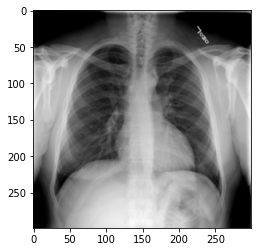

COVID chest x-ray


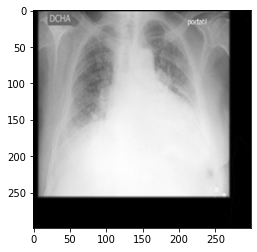

Viral Pneumonia chest x-ray


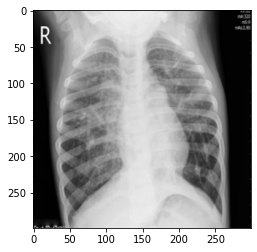

In [3]:
img_path = '/content/drive/My Drive/Dataset2/'
 
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')
 
# Show Images
 
print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("COVID chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

# Image pre-processing and train-test split

In [4]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

id   label
count                                     13677   13677
unique                                    13677       3
top     Viral Pneumonia/Viral Pneumonia-834.png  Normal
freq                                          1    8908

In [5]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  freq_a.columns = ['Label','absolute frequency']
  return freq_a
frequency_plot(df)

Label  absolute frequency
0           Normal                8908
1            COVID                3425
2  Viral Pneumonia                1344

In [6]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf
 
#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
 
traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [7]:
frequency_plot(traindf)

Label  absolute frequency
0           Normal                6680
1            COVID                2569
2  Viral Pneumonia                1008

In [8]:
frequency_plot(valdf)

Label  absolute frequency
0            COVID                 428
1           Normal                1114
2  Viral Pneumonia                 168

In [9]:
frequency_plot(testdf)

Label  absolute frequency
0            COVID                 428
1           Normal                1114
2  Viral Pneumonia                 168

# Image Data Generator

In [10]:
BATCH_SIZE = 50
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [11]:
 
"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
 
print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="Dataset2",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 

print("Creating train generator...")
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="Dataset2",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="Dataset2",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",  
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 10257 validated image filenames belonging to 3 classes.
Creating train generator...
Found 1710 validated image filenames belonging to 3 classes.

Creating val generator...
Found 1710 validated image filenames belonging to 3 classes.


# Classifier Model
## Importing EfficientnetB0 model

In [12]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-pd39wtbj
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-pd39wtbj
     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=f6803e1e82298998fbdee93574328acaa8c9bdc9dc6887fa9d3d7092171a8d44
  Stored in directory: /tmp/pip-ephem-wheel-cache-by0lb6gl/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [13]:
import efficientnet.tfkeras as enet
base_model =enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights="imagenet",classes=2)
#Freeze base convolutional layers
base_model.trainable = False

base_model.summary()

16818176/16804768 [==============================] - 1s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________

# Addition of fully connected layers

In [14]:
from keras.layers import AveragePooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
from keras.models import Model 
from keras.layers import Flatten 

 
x = base_model.output
x = Flatten()(x)  
x = BatchNormalization()(x)
x = Dropout(0.30)(x)
 
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
 
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
# Output layer
predictions = Dense(3, activation="softmax")(x) 
model= Model(inputs = base_model.input, outputs = predictions)

#model.summary()

# Model visualization




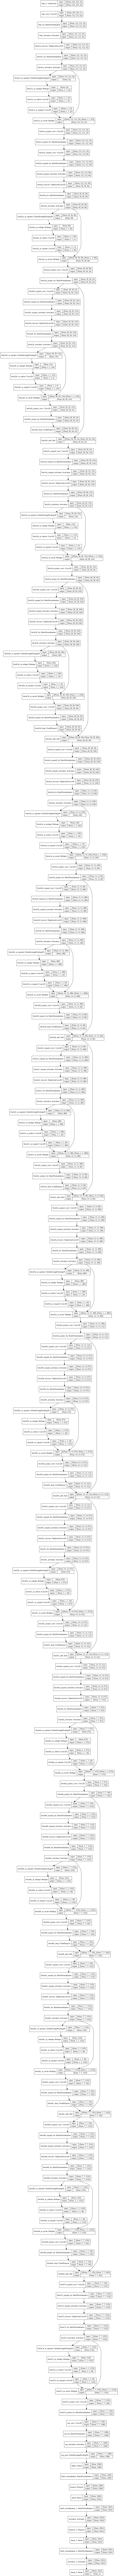

In [15]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

#Training the classification model

In [ ]:
 
EPOCHS =21
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
     #loss='binary_crossentropy',
    loss='categorical_crossentropy',
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
     metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
50/50 [==============================] - 82s 2s/step - loss: 0.1367 - recall_3: 0.9604 - precision_3: 0.9732 - acc: 0.9660 - val_loss: 0.1415 - val_recall_3: 0.9760 - val_precision_3: 0.9799 - val_acc: 0.9760
Epoch 2/21
50/50 [==============================] - 79s 2s/step - loss: 0.1268 - recall_3: 0.9692 - precision_3: 0.9770 - acc: 0.9744 - val_loss: 0.1449 - val_recall_3: 0.9680 - val_precision_3: 0.9758 - val_acc: 0.9720
Epoch 3/21
50/50 [==============================] - 79s 2s/step - loss: 0.1303 - recall_3: 0.9648 - precision_3: 0.9742 - acc: 0.9704 - val_loss: 0.1736 - val_recall_3: 0.9480 - val_precision_3: 0.9595 - val_acc: 0.9520
Epoch 4/21
50/50 [==============================] - 81s 2s/step - loss: 0.1266 - recall_3: 0.9692 - precision_3: 0.9743 - acc: 0.9728 - val_loss: 0.1715 - val_recall_3: 0.9560 - val_precision_3: 0.9560 - val_acc: 0.9560
Epoch 5/21
50/50 [==============================] - 78s 2s/step - loss: 0.1062 - recall_3: 0.9711 - precision_3: 0.9799 

'\nacc=history.history[\'acc\'], label=\'train data\'\nval_acc=history.history[\'val_acc\']\nloss=history.history[\'loss\']\nval_loss=history.history[\'val_loss\']\n \nplt.plot( acc)\nplt.plot( val_acc)\n#plt.title(\'Training and validation accuracy\')\nplt.title(\'PretrainedResnet50 Train/Test Loss\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Number of Epochs\')\nplt.legend(loc="upper left")\n \nplt.figure()\n'

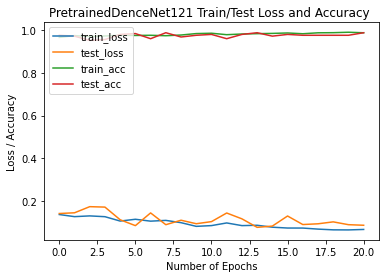

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
 
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="test_acc")
plt.title("PretrainedEfficientNetB0 Train/Test Loss and Accuracy ")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="upper left")
 
 

# Confusion Matrix  & Pres  & Recall   & F1-Score


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 407   16    5]
 [  13 1097    4]
 [   0    0  168]]
classification_Report
              precision    recall  f1-score   support

       COVID       0.97      0.95      0.96       428
      NORMAL       0.99      0.98      0.99      1114
   PNEUMONIA       0.95      1.00      0.97       168

    accuracy                           0.98      1710
   macro avg       0.97      0.98      0.97      1710
weighted avg       0.98      0.98      0.98      1710



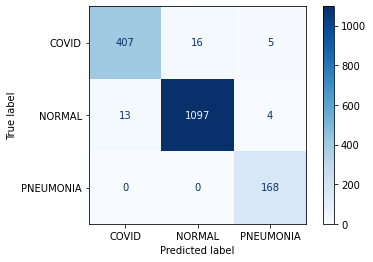

In [ ]:
# Confusion Matrix  & Pres  & Recall   & F1-Score
 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
 
target_names = ['COVID', 'NORMAL', 'PNEUMONIA']
label_names = [0,1,2]
 
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred ,  axis = 1)
 
cm = confusion_matrix(test_generator.classes, y_pred, labels = label_names)
 
 
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
 
print('classification_Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
 
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()

#Grad_cam

In [ ]:

def proc_img(img_path):
  "process the image"
  # `img` is a PIL image of size 224x224
  img = image.load_img(img_path, target_size=(224, 224))

  # `x` is a float32 Numpy array of shape (224, 224, 3)
  x_img = image.img_to_array(img)

  # We add a dimension to transform our array into a matrix
  # of size (1, 224, 224, 3)
  x_img = np.expand_dims(x_img, axis=0)

  # Finally we preprocess the batch
  # (this does channel-wise color normalization)
  #x_img = preprocess_input(x_img)
  x_img = preprocess_input(x_img)
  return x_img

In [ ]:
tf.compat.v1.disable_eager_execution()
"""To visualize which parts of the image are the most important for the each  
label for the classifier, let’s set up the Grad-CAM process."""

blck = 'top_conv' 
def xray_CAM(x_img, blck, label): 
  "gives the CAM heatmap"

  # the prediction vector
  pred_output = model.output[:, label]

  # The is the output feature map of the `top_conv ` layer,
  # the last convolutional layer in efficientNet
  last_conv_layer = model.get_layer(blck)

  # This is the gradient of the image's class with regard to
  # the output feature map of `top_conv `
  grads = K.gradients(pred_output, last_conv_layer.output)[0]

  # This is a vector of shape (1024,), where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us to access the values of the quantities we just defined:
  # `pooled_grads` and the output feature map of `top_conv`,
  # given a sample image
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # These are the values of these two quantities, as Numpy arrays,
  # given our sample image of two elephants
  pooled_grads_value, conv_layer_output_value = iterate([x_img])

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the elephant class
  for i in range(1280): # we have 1280 features in our last conv layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(conv_layer_output_value, axis=-1) # create a heatmap
  heatmap = np.maximum(heatmap, 0)  # remove negative values
  heatmap /= np.max(heatmap)  # normalize
  
  return heatmap

In [ ]:
def show_on_xray(img_path, heatmap):
  # We use cv2 to load the original image
  img = cv2.imread(img_path)

  # We resize the heatmap to have the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  # We convert the heatmap to RGB
  heatmap = np.uint8(255 * heatmap)

  # We apply the heatmap to the original image
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # 0.4 here is a heatmap intensity factor
  superimposed_img = heatmap * 0.4 + img

  ## Save the image to disk
  cv2.imwrite('./covido_test.jpg', superimposed_img)
  img_samp = cv2.imread('./covido_test.jpg')  #OpenCV has BGR order
  img_samp = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)  #matplotlib has RGB order
  

  cv2.imwrite('./pnemonia-testo.jpg', superimposed_img)
  img_samp_ = cv2.imread('./pnemonia-testo.jpg')  #OpenCV has BGR order
  img_samp_ = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)  #matplotlib has RGB order

  plt.imshow(img_samp)
  # plt.imshow(img_samp_)

In [ ]:
from keras.preprocessing import image

import keras
from keras import backend as K 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.layers.normalization import BatchNormalization
#from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
#from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
#matrice +grad cam
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from skimage.segmentation import slic
#from keras import backend as K
import tensorflow as tf

# The local path to our target image
img_path = '/content/drive/My Drive/Dataset2/COVID/covido_test.jpg'
x_img = proc_img(img_path)

img_pathpneumonia ='/content/drive/My Drive/Dataset2/Viral Pneumonia/pnemonia-testo.jpg'


x_img_ = proc_img(img_pathpneumonia)

COVID chest x-ray


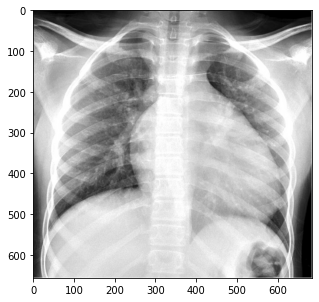

Viral Pneumonia chest x-ray


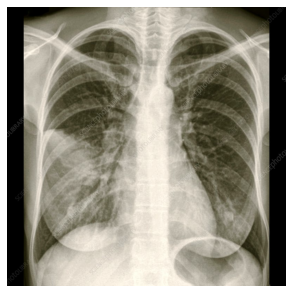

In [ ]:
print("COVID chest x-ray")
plt.rcParams['figure.figsize'] = (5.0, 10.0)
img_samp = cv2.imread(img_path)
plt.imshow(img_samp);
plt.show()
plt.axis("off")


print("Viral Pneumonia chest x-ray")
plt.rcParams['figure.figsize'] = (5.0, 7.0)
img_sampp = cv2.imread(img_pathpneumonia)
plt.imshow(img_sampp);


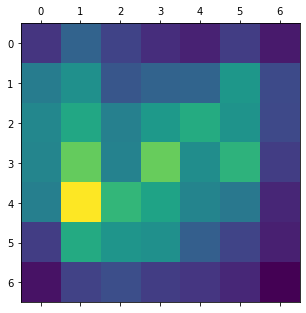

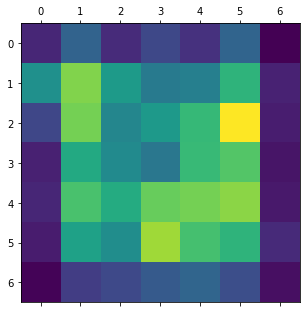

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
heatmap = xray_CAM(x_img, blck, 1)
plt.matshow(heatmap)
plt.show()

plt.rcParams['figure.figsize'] = (5.0, 5.0)
heatmap = xray_CAM(x_img_, blck, 1)
plt.matshow(heatmap)
plt.show()

COVID chest x-ray _  Grad_Cam


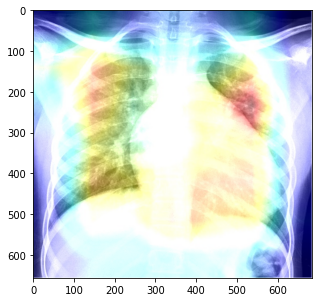

Pneumonia chest x-ray _  Grad_Cam


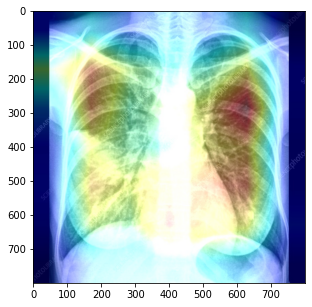

In [ ]:
print("COVID chest x-ray _  Grad_Cam")
plt.rcParams['figure.figsize'] = (5.0, 5.0)
show_on_xray(img_path, heatmap)
plt.show()
print("Pneumonia chest x-ray _  Grad_Cam")
plt.rcParams['figure.figsize'] = (5.0, 5.0)
show_on_xray(img_pathpneumonia, heatmap)

# Lime

In [ ]:
!pip install lime


     |████████████████████████████████| 275 kB 14.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ef458d19fdf0215bcf860ace00fa1c1d6acdca84be0fe7d2eaa231659354234d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries

In [ ]:

img_path_ = '/content/drive/My Drive/Dataset2/Viral Pneumonia/pnemonia-testo.jpg'
img_path = '/content/drive/My Drive/Dataset2/COVID/covido_test.jpg'

COVID chest x-ray


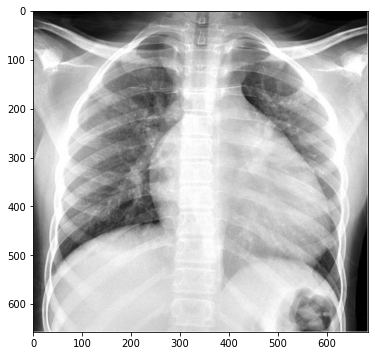

Pneumonia chest x-ray 


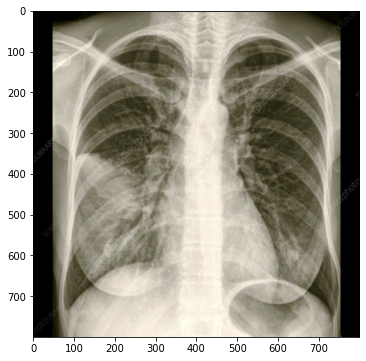

In [ ]:
print("COVID chest x-ray")
plt.rcParams['figure.figsize'] = (6.0, 6.0)
img_samp_n = cv2.imread(img_path)
plt.imshow(img_samp_n);
plt.show()
print("Pneumonia chest x-ray ")
plt.rcParams['figure.figsize'] = (6.0, 6.0)
img_samp_n = cv2.imread(img_path_)
plt.imshow(img_samp_n);
plt.show()

In [ ]:
p_img = proc_img(img_path)

p_img_ = proc_img(img_path_)

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:

explanation = explainer.explain_instance(p_img[0], model.predict, 
                                         top_labels=2, hide_color=0,
                                         num_samples=1000,
                                         distance_metric='cosine')


explanation_ = explainer.explain_instance(p_img_[0], model.predict, 
                                         top_labels=2, hide_color=0,
                                         num_samples=1000,
                                         distance_metric='cosine')

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  0%|          | 0/1000 [00:00<?, ?it/s]

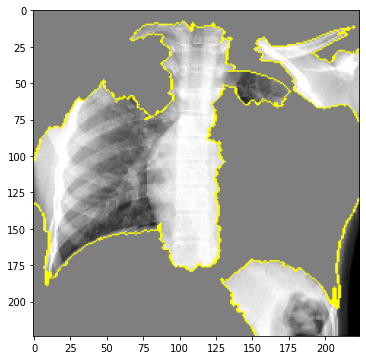

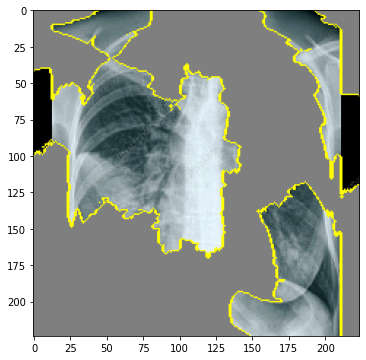

In [ ]:
temp, mask = explanation.get_image_and_mask(label=2, positive_only=True, 
                                            num_features=15, hide_rest=True,
                                            min_weight=0.0000004
                                            )
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(mark_boundaries(tempp, mask));
plt.show()

temp, mask = explanation_.get_image_and_mask(label=2, positive_only=True, 
                                            num_features=15, hide_rest=True,
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(mark_boundaries(tempp, mask));
plt.show()

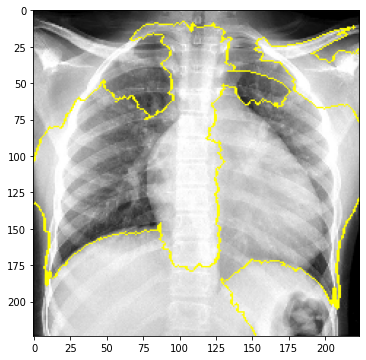

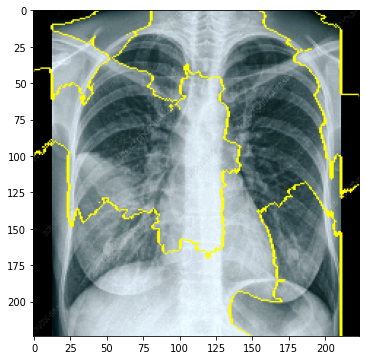

In [ ]:
temp, mask = explanation.get_image_and_mask(label=2, positive_only=True, 
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)

tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));
plt.show()

temp, mask = explanation_.get_image_and_mask(label=2, positive_only=True, 
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)

tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));


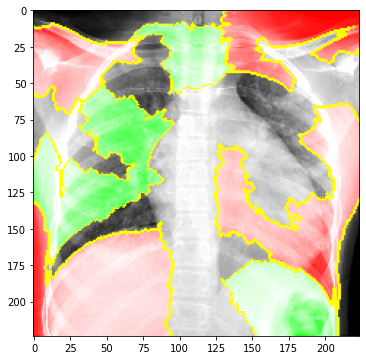

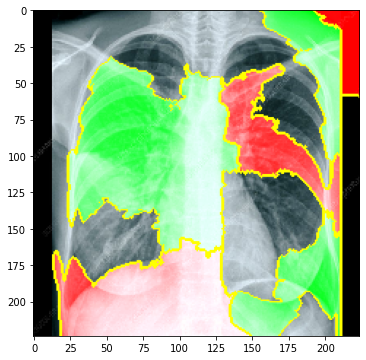

In [ ]:

temp, mask = explanation.get_image_and_mask(label=2, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));
plt.show()


temp, mask = explanation_.get_image_and_mask(label=2, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));

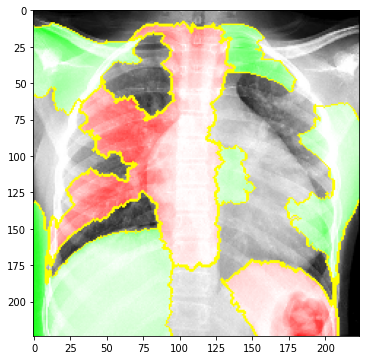

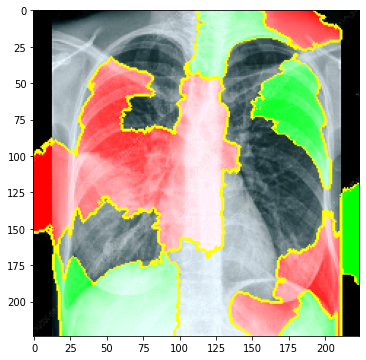

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0005)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));
plt.show()

temp, mask = explanation_.get_image_and_mask(label=0, positive_only=False, 
                                            num_features=15, hide_rest=False, 
                                            min_weight=0.0005)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));